## Part 3 of Data Analysis of craigslist SF Bay Area Rental Listings Data:

### Examine price per square feet by subregion so we can compare subregion rental prices using this sort standardized measure, a sort of KPI. For example, SF rentals might be smaller on average than Peninsula listings, which would indicate a bigger gap in rental prices than if we merely compared average prices. 

### 2nd, let's re-do panel regressions after adding an additional filtering/transformation process to the data. First, a) remove sqft extreme outliers; b) remove rental price outliers after identifying them via IQR. 2nd, we will apply this additional filter: namely, remove any SF Bay Area cities that have fewer than 60 listings over the sample period of October 2021-March 10, 2022.



In [2]:
# imports:
# file processing
import os
import glob

# data analysis libraries & SQL libraries
import numpy as np
import pandas as pd
# SQL ODBC for API connection between Python & SQL Server
import pyodbc
import json


# data visualization:
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# import data from rental table
class SQL_Database():
    def __init__(self, sql_config_path):

        with open(sql_config_path, 'r') as fh:
            config = json.load(fh)

        self.driver = config['driver']
        self.server = config['server']
        self.database = config['database']
        self.username = config['username']
        self.password = config['password']
        print(f"Name of connected database:\n{self.database}")


    def import_SQL_to_df(self, sql_query):
        """Import dataset by using SQL query and Pandas' read_sql() method"""
        conn = pyodbc.connect(
            f'DRIVER={self.driver};'
            f'SERVER={self.server};'
            f'DATABASE={self.database};'
            f'UID={self.username};'
            f'PWD={self.password};'
            'Trusted_Connection=yes;'
        )

        # establish connection to SQL Server database, by passing in the database name, etc., using a with statement so it will automatically close the connection & cursor once the with statement has completed execution:
        # initialize cursor so we can execute SQL code
        cursor = conn.cursor() 

        # query to select all records where price > $100, since such a price is essentially impossible and likely a typo from the original scraped rental listing
        # specify SQL query
        sql = sql_query 

        # export SQL query results to Pandas' DataFrame
        df = pd.read_sql(sql,conn)  # export results of SQL query to Pandas' DataFrame

        cursor.close()
        conn.close()
        return df


## import data with no sqft nu+lls and price >$1, via SQL query to Pandas' df
# specify path to json file containing SQL configuration/username data
sql_config_path = "D:\\Coding and Code projects\\Python\\craigslist_data_proj\\CraigslistWebScraper\\SQL_config\\config.json" 

SQL_db = SQL_Database(sql_config_path)  # NB: be sure to pass in path to the json SQL configuration file so we can load in the needed username, password, and configuration data to be able to access the SQL database

# specify query for data selection
query = """SELECT * FROM rental WHERE price > 100;"""
# import data to DataFrame via SQL query and Pandas' read_sql() method
df = SQL_db.import_SQL_to_df(query)
df.info() # sanity check

Name of connected database:
craigslist
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17956 entries, 0 to 17955
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   listing_id               17956 non-null  int64         
 1   sqft                     17956 non-null  int64         
 2   city                     17956 non-null  object        
 3   price                    17956 non-null  int64         
 4   bedrooms                 17956 non-null  int64         
 5   bathrooms                17956 non-null  float64       
 6   attr_vars                17956 non-null  object        
 7   date_of_webcrawler       17956 non-null  datetime64[ns]
 8   kitchen                  17956 non-null  int64         
 9   date_posted              17956 non-null  datetime64[ns]
 10  region                   17956 non-null  object        
 11  sub_region               17956 non-null  object       

### Data cleaning:


### Remove records with very high and low sqft outliers that are likely incorrect due to data entry errors or simply too extreme to readily include in the statistical analysis and visualizations:

### Let's assume the exteme values of sqft that are not reasonable are a) sqft > 10k, or b) sqft <90:

In [4]:
# remove listings that are very likely posted with incorrect number of bedrooms
def delete_listings_with_suspicious_sqft_vals(df):
    """Remove listings that have suspiciously or even iompossibly high or low sqft values.
    Namely: a) sqft > 10k or b) sqft < 90 """
    # remove listings with suspicious sqft vals:  
    return df.loc[~((df.sqft>10000) | (df.sqft < 90)) ]  # remove any rows with sqft > 10k or sqft <90

# filter data based on sqft:
df = delete_listings_with_suspicious_sqft_vals(df)

# sanity check
print(f'Having cleaned the data, the new min and max sqft values are: {df.sqft.min()} & {df.sqft.max()}')  

Having cleaned the data, the new min and max sqft values are: 90 & 10000


### Data cleaning--cont'd:

### Remove bedroom listings that likely have suspiciosly low rental prices, given the number of bedrooms. For example, some supposed 5-6 bedrooms listings are denoted as being apartments and have rental prices well below $3,500. This is dubious and likely due to data entry erorrs. Thus, let's remove these listings from the dataset:

In [5]:
# remove listings that are very likely posted with incorrect number of bedrooms
def delete_listings_with_incorrect_bedroom_and_price_vals(df):
    """Remove apartment property type that have suspiciously low rental prices and an absurdly high number of bedrooms: namely--6 or more bedrooms."""
    # remove listings that are of apt type, have 6+ bedrooms, and have rental price < $3,500  
    return df.loc[~((df.bedrooms>5) & (df.price < 3500))]

#filter data
df = delete_listings_with_incorrect_bedroom_and_price_vals(df)
# sanity check
df.bedrooms.value_counts()  # NB: there should be fewer listings with > 5 bedrooms  

1    7259
2    4176
0    1262
3     354
4      40
5       9
Name: bedrooms, dtype: int64

### Ensure that each set of indicator variables that are supposed to be mutually exclusive are in fact mutually exclusive (ie, sum of each set of indicator variable per row or record listing must equal a total of 1 at most):

In [7]:
# identify whether any sets of indicator variables are perfectly collinear, anmd remove any indicator variabels that should be mutually exclusive, but are not--ie, sum >=1 for the set of indicator variables for a given rental listing (ie, row)
def identify_perfect_collinearity(df, indicator_var_group_col_names:list, sum_of_indicator_groups_colname):
    """Using a list of all columns within a group of idicator variables, take the .sum() along the rows (ie, axis=1) identify if any rows have a 1 in *more than 1* of the cols by seeing whether the .sum() of the indicator cols along the rows (ie, axis=1) is greater than 1. 
    If this is the case, then the given group of indicator vars is *not* pefectly collinear (even though they theoretically should be)!"""
    # compute sum of given group of indicator var cols along rows (ie, axis=1), and add this sum as new col:
    df[sum_of_indicator_groups_colname] = df[indicator_var_group_col_names].sum(axis=1)  # take sum of group of indicator var cols 

    # see whether any rows (ie, rental listings) have a sum >1 among the group of indicator cols. If so, then *remove* these given rows (rental listings).
    row_filter = df[df[sum_of_indicator_groups_colname] > 1]  # specify filter criteria
    # sanity check
    print(f"The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:\n{row_filter}")
    # remove these problematic rows from dataset, by applying the negation of the filter (ie, with sum <= 1):
    df = df[df[sum_of_indicator_groups_colname] <= 1]
    # remove sum_of_indicator_groups_colname since it's no longer needed
    df = df.drop(columns=[sum_of_indicator_groups_colname])
    return df


# property/home indicator var cols group
housing_type_indicators = ['apt', 'in_law_apt', 'condo', 'townhouse', 'cottage_or_cabin', 'single_fam', 'duplex', 'flat', 'land']


df = identify_perfect_collinearity(df, housing_type_indicators, 'housing_type_row_sum')

The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:
      listing_id  sqft          city  price  bedrooms  bathrooms  \
62    7388669952  9500      Petaluma   2175         2        1.0   
562   7397023232  9900    San Rafael   1995         1        1.0   
567   7397180416  7200    Santa Rosa   1850         1        1.0   
661   7398716416  8500        Novato   2865         2        2.0   
692   7398986240  4400    San Rafael   1950         0        1.0   
698   7399021568  6600    Santa Rosa   2046         1        1.0   
791   7399582208  7520    Santa Rosa   2132         1        1.0   
809   7399651328  6800      Petaluma   2380         1        1.0   
854   7399968256  8350        Novato   2415         2        1.0   
924   7400109056  9500    Santa Rosa   2441         2        1.0   
931   7400120832  9540    San Rafael   3195         2        1.0   
1640  7405201920  5250   

In [8]:
# next, apply filter to laundry indicators

# specify laundry indicator var names
laundry_indicators = ['laundry_in_bldg', 'no_laundry', 'washer_and_dryer', 'washer_and_dryer_hookup', 'laundry_on_site']
 
df = identify_perfect_collinearity(df, laundry_indicators, 'laundry_ind_sum')

The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:
       listing_id  sqft                 city  price  bedrooms  bathrooms  \
37     7386295296  7430            Daly City   1400         0        1.0   
38     7387141632  5000         Walnut Creek   1900         1        1.0   
67     7389036544  4480              Concord   1600         1        1.0   
90     7389910528  1800         Walnut Creek   1400         1        1.0   
102    7390080000  6300  South San Francisco   1650         1        1.0   
...           ...   ...                  ...    ...       ...        ...   
17630  7454707200  5000             San Jose   1825         1        1.0   
17647  7454804992  3130             Campbell   1550         1        1.0   
17689  7455145472  8000             Campbell   1600         1        1.0   
17738  7455324672  4000          Santa Clara   1600         1        1.0   
17952

In [10]:
# flooring type indicators 
flooring_type_indicators = ['flooring_carpet',	'flooring_wood', 'flooring_tile', 'flooring_hardwood', 'flooring_other']

df = identify_perfect_collinearity(df, flooring_type_indicators, 'flooring_types')

The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:
Empty DataFrame
Columns: [listing_id, sqft, city, price, bedrooms, bathrooms, attr_vars, date_of_webcrawler, kitchen, date_posted, region, sub_region, cats_OK, dogs_OK, wheelchair_accessible, laundry_in_bldg, no_laundry, washer_and_dryer, washer_and_dryer_hookup, laundry_on_site, full_kitchen, dishwasher, refrigerator, oven, flooring_carpet, flooring_wood, flooring_tile, flooring_other, apt, in_law_apt, condo, townhouse, cottage_or_cabin, single_fam, duplex, flat, land, is_furnished, attached_garage, detached_garage, carport, off_street_parking, no_parking, EV_charging, air_condition, no_smoking, flooring_types]
Index: []

[0 rows x 47 columns]


In [11]:
# parking options indicators
parking_options_indicators = ['attached_garage','detached_garage', 'carport', 'off_street_parking', 'no_parking']

df = identify_perfect_collinearity(df, parking_options_indicators, 'parking_ops')

The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:
Empty DataFrame
Columns: [listing_id, sqft, city, price, bedrooms, bathrooms, attr_vars, date_of_webcrawler, kitchen, date_posted, region, sub_region, cats_OK, dogs_OK, wheelchair_accessible, laundry_in_bldg, no_laundry, washer_and_dryer, washer_and_dryer_hookup, laundry_on_site, full_kitchen, dishwasher, refrigerator, oven, flooring_carpet, flooring_wood, flooring_tile, flooring_other, apt, in_law_apt, condo, townhouse, cottage_or_cabin, single_fam, duplex, flat, land, is_furnished, attached_garage, detached_garage, carport, off_street_parking, no_parking, EV_charging, air_condition, no_smoking, parking_ops]
Index: []

[0 rows x 47 columns]


### Remove columns with only 0s:

In [12]:
def remove_cols_with_only_0s(df):
    """Remove any columns that have only 0s, since including them 
    in a regression model would result in perfect multicollinearity."""
    df = df.loc[:, (df != 0).any(axis=0)]
    return df

df = remove_cols_with_only_0s(df)

In [13]:
## remove outliers

# IQR (Interquartile) range approach for outlier detection--remove extreme outliers:

# calculate 1st & 3rd quartiles, IQR, and then the min and max thresholds based on IQR, etc
def IQR_outlier_detection_and_removal(df, col_with_outliers, iqr_thres=1.5):
    """ 
    Detect outliers based on IQR. Remove outliers based on being 1.5 times above or below Q3 & Q1, respectively.
    Check if input is Series or DataFrame, and apply the function accordingly.  
    """
    import scipy.stats as stats
    # check if input data is a Series object: 
    if isinstance(df, pd.core.series.Series):  # if df is in fact a Pandas' Series
        # calculate the 1st & 3rd quartiles:
        Q1 =  df.quantile(q=.25)  # 1st quartile
        Q3 =  df.quantile(q=.75) # 3rd quartile
        IQR = Q3 - Q1    # calculate interquartile range (ie, IQR)
        min_thres = Q1 - IQR*iqr_thres # define min threshold --namely: subtract Q1 from IQR times 3 (given iqr_thres parameter)
        max_thres = Q3 + IQR*iqr_thres  # define max threshold
        print(f"Q1: {Q1},\n Q3: {Q3}, \n IQR: {IQR}, \n min threshold: {min_thres}, \n max thres: {max_thres}\n") # print Q1, Q2, IQR, and thresholds 
        data_sans_outliers =  df[(df > min_thres) & (df < max_thres)] # remove outliers--ie, above the max threshold OR below the min threshold
        print(f"Number of records in the dataset after removing outliers: \n{data_sans_outliers.shape[0]} \n")

    else:  # if input is a DataFrame
        # calculate the 1st & 3rd quartiles:
        Q1 =  df[col_with_outliers].quantile(q=.25)  #calculate 1st quartile
        Q3 =  df[col_with_outliers].quantile(q=.75) #calculate 3rd quartile
        IQR = Q3 - Q1    # calculate interquartile range (ie, IQR)
        min_thres = Q1 - IQR*iqr_thres # define min threshold --namely: subtract Q1 from IQR times 3 (given iqr_thres parameter)
        max_thres = Q3 + IQR*iqr_thres  # define max threshold
        print(f"Q1: {Q1},\n Q3: {Q3}, \n IQR: {IQR}, \n min threshold: {min_thres}, \n max thres: {max_thres}\n") # print Q1, Q2, IQR, and thresholds 
        data_sans_outliers =  df[(df[col_with_outliers] > min_thres) & (df[col_with_outliers] < max_thres)] # remove outliers--ie, above the max threshold OR below the min threshold
        print(f"Number of records in the dataset after removing outliers: \n{data_sans_outliers.shape[0]} \n")
    
    return data_sans_outliers

#remove outliers via function:
df = IQR_outlier_detection_and_removal(df, 'price')


# sanity check
def check_for_new_min_and_max_after_outlier_removal(df, col_with_outliers):
    if isinstance(df, pd.core.series.Series):  # if df is in fact a Pandas' Series
            print(f"New min & max values for price wrt training dataset (after removing outliers) is:\nmax:{df.max()}\n& min:{df.min()}")
    else:
        print(f"New min & max values for price wrt training dataset (after removing outliers) is:\nmax:{df[col_with_outliers].max()}\n& min:{df[col_with_outliers].min()}")
        
check_for_new_min_and_max_after_outlier_removal(df, 'price')

Q1: 2143.25,
 Q3: 2988.0, 
 IQR: 844.75, 
 min threshold: 876.125, 
 max thres: 4255.125

Number of records in the dataset after removing outliers: 
12032 

New min & max values for price wrt training dataset (after removing outliers) is:
max:4255
& min:880


### Calculate price per square foot as a standardized measure of comparing rental price"

In [22]:
## Develop a standardized measure (a KPI if you will) in which we can compare cities and subregions by rental prices, but account for differences in rental home/property size:

### Ie: calculate price per sq feet
df['price_per_sqft'] = df.price/df.sqft
#sanity check
df['price_per_sqft'].head()

2    0.546154
4    0.266768
5    0.347368
6    0.633397
7    0.387500
Name: price_per_sqft, dtype: float64

In [32]:
df['price_per_sqft'].max()

11.61111111111111

### Compare subregions by price_per_sqft--use a barchart of avg price per sqft, with hue of subregion

In [ ]:
# avg price per sqft by subregion

avg_sqft_price

### Compare subregions by price_per_sqft--use a boxplot with hue of subregion

<AxesSubplot:xlabel='bedrooms', ylabel='price_per_sqft'>

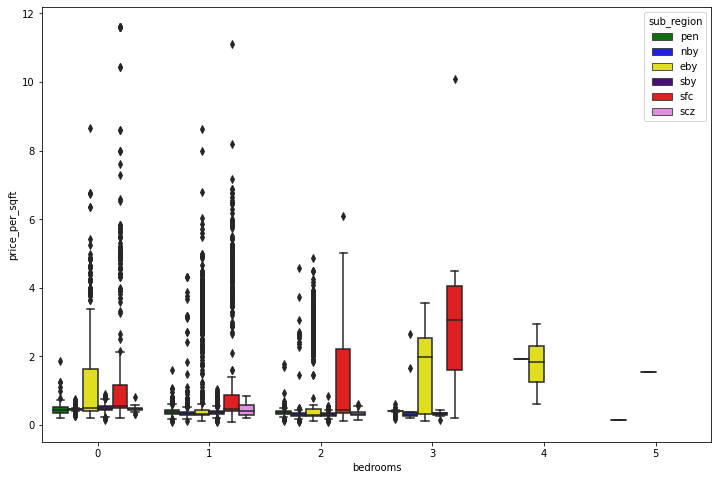

In [19]:
def boxplot_with_y_var_and_hue(df, x_axis_var:str, y_axis_var:str, hue_option:str, custom_palette:dict):
    if hue_option is not None:        
        plt.figure(figsize=(12,8))
        return sns.boxplot(data=df, x=x_axis_var, y= y_axis_var, hue=hue_option, palette= custom_palette)
    else:  # ie, if we do *not* want to use a hue
        plt.figure(figsize=(12,8))
        return sns.boxplot(data=df, x=x_axis_var, y= y_axis_var)


#  boxplot to visualize distribution of price_per_sqft by subregion

# create a dictionary defining a customized palette of colors to use for each subregion:
subregion_palette = {"nby": "b", "eby": "yellow", "pen":"g", "sfc":"red", "sby":"indigo", "scz":"violet"}

hue_op_subregion = "sub_region"

# boxplot
boxplot_with_y_var_and_hue(df, "bedrooms", "price_per_sqft", hue_op_subregion, subregion_palette)

### The boxplot suggests...

### Next, examine price per sqft by number of bedrooms & subregion

In [ ]:
#price per sqft by number of bedrooms & subregion
boxplot_with_y_var_and_hue(df, "bedrooms", "price_per_sqft", hue_op_subregion, subregion_palette)

### Data cleaning--cont'd:

### As a result, let's remove outliers based on IQR (interquartile range), let's use 1.5 times IQR as our rule for removing outliers: